# Udacity Data Engineer Nanodegree

## Project: Complaints Analytics

### 02. Data Exploration and Visualisation

The first step in working with the data set is to load the data and identify what information is included in the data set. This is an important step to eventually work with this data, and to know what kind of characteristics I have to work with when transforming and grouping the data!

In this way, I prepare this notebook to do all the data exploration and pattern observation on the features given to it and the data distribution, as well as the definition of our final data set, to be worked on in the next step of pre-processing and data feature engineering.

#### Exploratory Data Analysis (EDA)
With resources from different EDA and data Pre-Processing methodologies and libraries, I'll explore and visualise this data from the existing data set and analyse the possible metrics that will be used to understand the solution to the problem I propose to answer. Thus, I'll try to identify the relationship between each of the characteristics and features of the complaint.

I'll analyse:
* A general statistical summary of the data set, using EDA visualization tools
* Distribution of `complaints`, `product`, `sub_product`, `issue` and `sub_issue`
* Relationship of complaint text length and assigned product
* Relationship of the complaint narrative to the product allocated
* Relationship of the words of the complaint to the product
* Try to identify the relationship between the features
* I'll try to reduce our data subset


**Step 1 - Importing packages**

In [5]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import os
import re
import pickle
import IPython
from IPython.display import IFrame

# Ploting


# My libraries:
import sys
sys.path.insert(0, '../src/utils')
import helpers as helpers


# Warnings;
import warnings; warnings.simplefilter('ignore')

**Step 2 - Load worked dataset and copy to a dataframe with pandas**

In [6]:
# Load pickle file to a data frame
df_complaints = helpers.load_pickle('../data/raw','df_complaints');

df_complaints pickle file loaded successfully!


In [7]:
df_complaints = df_complaints.copy();

In [8]:
df_complaints.head(2).T

,0,1
Date received,2019-09-24,2019-09-19
Product,Debt collection,"Credit reporting, credit repair services, or o..."
Sub-product,I do not know,Credit reporting
Issue,Attempts to collect debt not owed,Incorrect information on your report
Sub-issue,Debt is not yours,Information belongs to someone else
Consumer complaint narrative,transworld systems inc. \nis trying to collect...,NaN
Company public response,NaN,Company has responded to the consumer and the ...
Company,TRANSWORLD SYSTEMS INC,Experian Information Solutions Inc.
State,FL,PA
ZIP code,335XX,15206


**Step 3 - A few general statistics about dataset**

I'll analyze here the high-level statistics of the complaint

In [9]:
df_complaints.shape

(2021440, 18)

Data set with 18 columns and more than 2.02 Million Records. 

This is a considerable data set.

In [10]:
df_complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2021440 entries, 0 to 2021439
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 277.

I find that there are many records to be found, particularly in the narrative of the complaint. This attribute is very important for our project.

Therefore, I'll have to filter all the complaints that do not have a narrative, because they do not interest us.

In [11]:
#identify nulls
df_complaints.isna().sum()

Date received                         0
Product                               0
Sub-product                      235165
Issue                                 0
Sub-issue                        605998
Consumer complaint narrative    1333289
Company public response         1174110
Company                               0
State                             37343
ZIP code                         198015
Tags                            1764243
Consumer consent provided?       692629
Submitted via                         0
Date sent to company                  0
Company response to consumer          2
Timely response?                      0
Consumer disputed?              1252972
Complaint ID                          0
dtype: int64

On this data set only have one numerical variable.

I'll analyze here the percentage of columns with text. From 1.8 million complaints, there are about 600,000 cases with text (~ 34% of the original dataset is not null). This is still a good number to work with.

In [12]:
# Percentage of columns with text
complaints_with_narrative = df_complaints['Consumer complaint narrative'].notnull().sum()
sub_product_with_text = df_complaints['Sub-product'].notnull().sum()
issue_with_text = df_complaints['Issue'].notnull().sum()
product_with_text  = df_complaints['Product'].notnull().sum()
sub_issue_with_text = df_complaints['Sub-issue'].notnull().sum()

print('Consumer complaint narrative % : ' + helpers.to_str(round((complaints_with_narrative/len(df_complaints)*100),1)));
print('Sub-product % : ' + helpers.to_str(round((sub_product_with_text/len(df_complaints)*100),1)));
print('Sub-issue % : ' + helpers.to_str(round((product_with_text/len(df_complaints)*100),1)));
print('Issue % : ' + helpers.to_str(round((issue_with_text/len(df_complaints)*100),1)));
print('Product % : ' + helpers.to_str(round((sub_issue_with_text/len(df_complaints)*100),1)));

Consumer complaint narrative % : 34.0
Sub-product % : 88.4
Sub-issue % : 100.0
Issue % : 100.0
Product % : 70.0


Analysing the above metrics, one realizes that the data set is considerably large to work locally. I'll have to filter the data set in some way so that I can explore and train it.

After analysis and taking into account the problem I have proposed, I'll select only the columns that interest us and I'll rename them, considering a new monenclature. The data set contains several characteristics that will not be necessary to solve the classification problem I propose to do. So, for a better analysis and understanding of the text classification problem, I'll build a new data set with fewer columns and with a new sorting.

In [20]:
def check_null_and_distribution(field):    
    print(f'Check null for {field}:\n\n')

    null_total_in_field = len(df_complaints[df_complaints[field].isna()].index)
    print(f'TOTAL NULL: {null_total_in_field}')
    
    field_len = len(list(df_complaints[field].unique()))
    print(f'TOTAL of unique values in field: {field_len}')
    
    dist_df = df_complaints \
        .groupby([field]) \
        .agg({'Complaint ID': 'count'}) \
        .sort_values(by='Complaint ID', ascending=False)
    print(dist_df.head())
    if field_len > 10:
        print(dist_df.tail())
        
    print('\n\n')

In [22]:
for field in ['Date received',
              'Product',
              'Sub-product',
              'Issue',
              'Sub-issue',
              'Consumer complaint narrative',
              'Company public response',
              'Company',
              'State',
              'ZIP code',
              'Tags',
              'Consumer consent provided?',
              'Submitted via',
              'Date sent to company',
              'Company response to consumer',
              'Timely response?',
              'Consumer disputed?']:

    check_null_and_distribution(field)

Check null for Date received:


TOTAL NULL: 0
TOTAL of unique values in field: 3403
               Complaint ID
Date received              
2017-09-08             3553
2017-09-09             2709
2021-01-05             2309
2020-12-29             2199
2020-12-14             2136
               Complaint ID
Date received              
2012-01-01               14
2011-12-24               11
2011-12-25               10
2017-04-22                9
2014-03-09                5



Check null for Product:


TOTAL NULL: 0
TOTAL of unique values in field: 18
                                                    Complaint ID
Product                                                         
Credit reporting, credit repair services, or ot...        671764
Debt collection                                           343854
Mortgage                                                  323982
Credit reporting                                          140432
Credit card or prepaid card                            

               Complaint ID
Submitted via              
Web                 1595296
Referral             209016
Phone                111738
Postal mail           79625
Fax                   25342



Check null for Date sent to company:


TOTAL NULL: 0
TOTAL of unique values in field: 3352
                      Complaint ID
Date sent to company              
2017-09-08                    3387
2017-09-09                    2656
2021-01-05                    2328
2021-03-03                    2222
2020-12-29                    2166
                      Complaint ID
Date sent to company              
2011-12-31                       1
2011-12-18                       1
2012-03-18                       1
2013-02-23                       1
2012-11-11                       1



Check null for Company response to consumer:


TOTAL NULL: 2
TOTAL of unique values in field: 9
                                 Complaint ID
Company response to consumer                 
Closed with explanation      

**Step 4 - Data set considering**

In [12]:
# rename the columns considered
df_complaints = df_complaints.rename(index=str, columns={"Product": "product", "Sub-product": "sub_product", "Issue": "issue", "Sub-issue": "sub_issue", "Consumer complaint narrative": "complaint_text", "Complaint ID": "complaint_id", "Company": "company"})

# Create a new dataframe with 6 columns
df_complaints = df_complaints[['complaint_id', 'complaint_text', 'issue', 'sub_issue','product', 'sub_product', 'company']].copy()

# new column for understand lenght of complaint_text - I have situations where there are no narratives.
df_complaints['complaint_text_length'] = df_complaints['complaint_text'].str.len()

df_complaints.head(3)

,complaint_id,complaint_text,issue,sub_issue,product,sub_product,company,complaint_text_length
0,3384392,transworld systems inc. \nis trying to collect...,Attempts to collect debt not owed,Debt is not yours,Debt collection,I do not know,TRANSWORLD SYSTEMS INC,98.0
1,3937683,NaN,Incorrect information on your report,Information belongs to someone else,"Credit reporting, credit repair services, or o...",Credit reporting,Experian Information Solutions Inc.,NaN
2,3379500,NaN,Incorrect information on your report,Information belongs to someone else,"Credit reporting, credit repair services, or o...",Credit reporting,Experian Information Solutions Inc.,NaN


In [13]:
# Remove missing values (NaN)
df_complaints = df_complaints[pd.notnull(df_complaints['complaint_text'])]

In [14]:
df_complaints.shape

(621347, 8)

I have reduced data set in 60%.

In [15]:
# Percentage of columns with text
complaints_with_narrative = df_complaints['complaint_text'].notnull().sum()
print('Complaint Narrative with text %: ' + helpers.to_str(round((complaints_with_narrative/len(df_complaints)*100),1)));

Complaint Narrative with text %: 100.0


In the next cell, print out some statistics about the length of text

In [16]:
df_complaints['log_length'] = df_complaints.complaint_text_length.apply(np.log2)

In [17]:
print('Metrics for Complaint Text length')
print('---')
print(f'Mean: {df_complaints.complaint_text_length.mean():.2f}')
print(f'Median: {df_complaints.complaint_text_length.median():.0f}')
print(f'Max: {df_complaints.complaint_text_length.max()}')
print(f'90th Percentile: {df_complaints.complaint_text_length.quantile(.9):.0f}')
print(f'95th Percentile: {df_complaints.complaint_text_length.quantile(.95):.0f}')

Metrics for Complaint Text length
---
Mean: 1070.26
Median: 707
Max: 32317.0
90th Percentile: 2304
95th Percentile: 3227


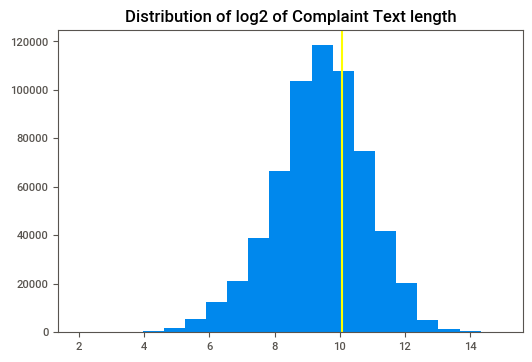

In [18]:
plt.hist(df_complaints.log_length,bins=20);
plt.title('Distribution of log2 of Complaint Text length')
plt.axvline(x=np.log2(df_complaints.complaint_text_length.mean()),color='yellow');

In [19]:
df_complaints.complaint_text_length.quantile(.95)

3227.0

**Conclusion**: Half of the Complaint Text is shorther than 707 characters. Though there are some very long pieces of text, 90 percent is shorter than 2304 and 95 percent is shorter than 3227.

In the next cell, print out some statistics about the data.

In [20]:
# print out some stats about the data
print('Number of complaints: ', df_complaints.shape[0])  # .shape[0] gives the rows 
# .unique() gives unique items in a specified column
print('Number of unique products: ', (len(df_complaints['product'].unique())))
print('Unique complaint products: ', (df_complaints['product'].unique()))

Number of complaints:  621347
Number of unique products:  18
Unique complaint products:  ['Debt collection'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Money transfer, virtual currency, or money service' 'Mortgage'
 'Vehicle loan or lease' 'Student loan' 'Credit card or prepaid card'
 'Checking or savings account' 'Credit card'
 'Payday loan, title loan, or personal loan' 'Consumer Loan' 'Payday loan'
 'Credit reporting' 'Other financial service' 'Bank account or service'
 'Money transfers' 'Prepaid card' 'Virtual currency']


The aim is to try to predict through classification what product I can assign to a complaint. So these two columns are really important for this project. 

Since our classification label is the `product`, it's important to understand it's distribution and balancing.

When I have certain high levels of balancing, that is, when a large % of the complaints are classified for number of products, I may have some problems in the accuracy of the models, because it can be high for this same reason. 

**Step 5 - Distribution of data**

To what extent is our data evenly distributed among the different products and complaint levels?

Our data set is quite large, especially with regard to examples of different product levels. The data is distributed slightly unbalanced.

In [21]:
# Show counts by different products and sub product of complaints

# group and count by product
counts_per_product=df_complaints.groupby(['product']).size().reset_index(name="Counts")
print("\nProduct:")
display(counts_per_product)

# group by sub product
counts_per_sub_product=df_complaints.groupby(['sub_product']).size().reset_index(name="Counts")
print("\nSub Product:")
display(counts_per_sub_product)

# group by product and sub product
counts_complaints_products=df_complaints.groupby(['product', 'sub_product']).size().reset_index(name="Counts")
print("\nProduct & Sub Product :")
display(counts_complaints_products)


Product:


,product,Counts
0,Bank account or service,14885
1,Checking or savings account,26070
2,Consumer Loan,9473
3,Credit card,18838
4,Credit card or prepaid card,44719
5,Credit reporting,31588
6,"Credit reporting, credit repair services, or o...",216693
7,Debt collection,125741
8,"Money transfer, virtual currency, or money ser...",11456
9,Money transfers,1497



Sub Product:


,sub_product,Counts
0,(CD) Certificate of deposit,274
1,Auto,1064
2,Auto debt,3122
3,CD (Certificate of Deposit),449
4,Cashing a check without an account,134
...,...,...
70,Traveler’s/Cashier’s checks,22
71,VA mortgage,4359
72,Vehicle lease,962
73,Vehicle loan,5141



Product & Sub Product :


,product,sub_product,Counts
0,Bank account or service,(CD) Certificate of deposit,274
1,Bank account or service,Cashing a check without an account,134
2,Bank account or service,Checking account,10113
3,Bank account or service,Other bank product/service,3477
4,Bank account or service,Savings account,887
...,...,...,...
90,Vehicle loan or lease,Lease,1962
91,Vehicle loan or lease,Loan,8899
92,Vehicle loan or lease,Title loan,12
93,Virtual currency,Domestic (US) money transfer,15


I can see that the products follow an unbalanced distribution, because there are 2 or 3 products that fit more complaints.

<BarContainer object of 18 artists>

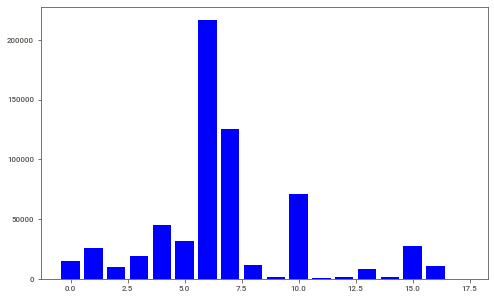

In [22]:
# counts
group = ['product']
counts = df_complaints.groupby(group).size().reset_index(name="Counts")

%matplotlib inline
plt.figure(figsize=(8,5))
plt.bar(range(len(counts)), counts['Counts'], color = 'blue')

Through the analysis I find that the number of complaints per product is unbalanced. The complaints are more focused on `creadit reporting`, `debt collection` and `mortgages`.

Some algorithms are often biased towards the majority class, not taking into account the distribution of data. Often the minority classes are treated as outliers and can easily be ignored.

There are 18 different product classes. However; It's observed that some classes are contained in others. For instance, `Credit card` and `Prepaid card` are contained in `Credit card or prepaid card` product. 
If have a new complaint about Credit card and I want to classify it, the algorithm can either classify this complaint as `Credit card` or `Credit card or prepaid` and it would be correct, but this would affect model performance. In order to avoid this problem, the names of some products were mapping to another product . I'll try to consolidate some of these products, joining the products with multiple or repeated descriptions (there are several products of `Loan`, `Credit Card`, `Prepaid`, `Payday`, etc...).

Even so, I'll have product with more proipherance, which may even be reasonable as they may allow us a greater accuracy.

Let's have a look at the products:

In [23]:
# Number of Complaints in each Product
product_balanced = (df_complaints.groupby('product').size()).sort_values(ascending = False)
print(product_balanced)

product
Credit reporting, credit repair services, or other personal consumer reports    216693
Debt collection                                                                 125741
Mortgage                                                                         70602
Credit card or prepaid card                                                      44719
Credit reporting                                                                 31588
Student loan                                                                     27132
Checking or savings account                                                      26070
Credit card                                                                      18838
Bank account or service                                                          14885
Money transfer, virtual currency, or money service                               11456
Vehicle loan or lease                                                            10873
Consumer Loan                      

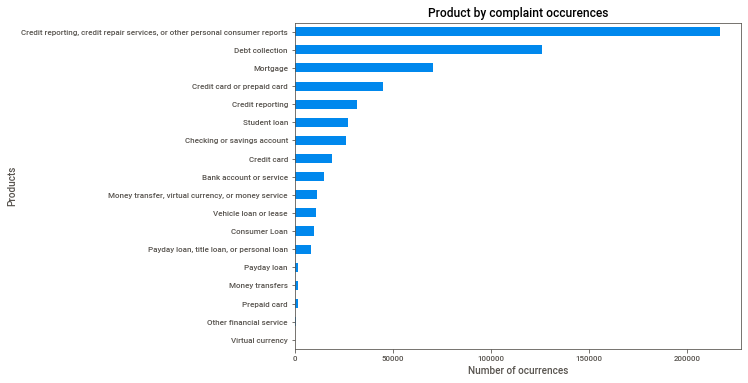

In [24]:
# Number of Complaints in each Product
fig = plt.figure(figsize=(8,6))
df_complaints.groupby('product').complaint_text.count().sort_values().plot.barh(ylim=0, title='Product by complaint occurences');
plt.xlabel('Number of ocurrences', fontsize = 10);
plt.ylabel('Products', fontsize = 10);
plt.show();

Since this is a stage of exploration, I don't seek to make major changes in our data set, I'll leave this work to the next phase. In the next phase of the project I'll prepare our final dataset, and for that I'll consider the following consolidation of the products:

* 'Credit reporting, credit repair services, or other personal consumer reports’ --> 'Credit reporting, repair, or other'
* 'Credit reporting': 'Credit reporting, repair, or other'
* 'Credit card' --> 'Credit card or prepaid card'
* 'Prepaid card' --> 'Credit card or prepaid card'
* 'Money transfer' --> 'Money transfer, virtual currency, or money service'
* 'Virtual currency' --> 'Money transfer, virtual currency, or money service'
* 'Payday loan, title loan, or personal loan' -->'Loan',
* 'Student loan' --> 'Loan'
* 'Consumer Loan' -->'Loan'
* 'Payday loan' -->'Loan'
* 'Vehicle loan or lease' --> 'Loan'

**Step 6 - Looking at a sample text**

When analysing examples of complaints I realise that it's complicated to read, because you have lots of characters and they are too long texts.

This text can be worked on, with to pre-processing techniques. I can remove the special characters, put the text in small letters, remove the numbers, vectorize, summarize the texts, etc.

In [25]:
# Create at a sample text
complaint_text = list(df_complaints.complaint_text[:3])[2]

# Converting to a list for TfidfVectorizer to use
list_sample_complaint_text = []
list_sample_complaint_text.append(complaint_text)
list_sample_complaint_text 

['Pioneer has committed several federal violations against me, a Private law abiding Federally Protected Consumer. Each violation is a statutory cost of {$1000.00} each, which does not include my personal cost and fees which shall be determined for taking time to address these issues. Violations committed against me include but not limited to : ( 1 ) Violated 15 USC 1692c ( a ) ; Communication without prior consent, expressed permission. ( 2 ) Violated 15 USC 1692d ; Harass and oppressive use of intercourse about an alleged debt. ( 3 ) Violated 15 USC 1692d ( l ) ; Attacking my reputation, accusing me of owing an alleged debt to you. ( 4 ) Violated 15 USC 1692e ( 9 ) ; Use/distribution of communication with authorization or approval. ( 5 ) Violated 15 USC 1692f ( l ) ; Attempting to collect a debt unauthorized by an agreement between parties.']

In [26]:
# Observing what words are extracted from a TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer;

TfidfVectorizer = TfidfVectorizer(stop_words='english', sublinear_tf=True);

check_TfidfVectorizer = TfidfVectorizer.fit_transform(list_sample_complaint_text);
#check_TfidfVectorizer = TfidfVectorizer.fit_transform(helpers.clean_text(list_sample_complaint_text))

print(TfidfVectorizer.get_feature_names());

['00', '1000', '15', '1692c', '1692d', '1692e', '1692f', 'abiding', 'accusing', 'address', 'agreement', 'alleged', 'approval', 'attacking', 'attempting', 'authorization', 'collect', 'committed', 'communication', 'consent', 'consumer', 'cost', 'debt', 'determined', 'distribution', 'does', 'expressed', 'federal', 'federally', 'fees', 'harass', 'include', 'intercourse', 'issues', 'law', 'limited', 'oppressive', 'owing', 'parties', 'permission', 'personal', 'pioneer', 'prior', 'private', 'protected', 'reputation', 'shall', 'statutory', 'taking', 'time', 'unauthorized', 'usc', 'use', 'violated', 'violation', 'violations']


I can rely on stop_word removal from tfidf. Through the tests, I see that it removes the punctuations and also all stop words. 
Therefore, I'll try to use tfidf as it is, but probably I'll apply the cleaning of the text in the next stage  (Text Processing):
1. converting all letters to lower
2. converting numbers into words 
3. removing white spaces
4. expanding some abbreviations
5. removing non ascii
6. remove wrong convertion characters from text
7. removing xxx since it will be treated as importand words by tf-idf vectorization

Do the product use their language?

I don't know, because the process is running forever, but probably all in `English`.


In [27]:
## Observing what words are extracted 
# from sklearn.feature_extraction.text import TfidfVectorizer;
# 
# df_complaints['complaint_language'] = df_complaints.complaint_text.apply(lambda x: helpers.detect_werror(x))
# 
# # Construct the set of stop-words in the target languages
# languages = ['polish','portuguese', 'bulgarian', 'russian', 'ukrainian', 'english', 'romanian']
# stop_words = []
# for language in languages:
#     stop_words.extend(get_stop_words(complaint_language))
#     print(stop_words)
# 
# TfidfVectorizer = TfidfVectorizer(stop_words=stop_words, sublinear_tf=True);
# 
# check_TfidfVectorizer = TfidfVectorizer.fit_transform(list_sample_complaint_text);
# #check_TfidfVectorizer = TfidfVectorizer.fit_transform(helpers.clean_text(list_sample_complaint_text))
# 
# print(TfidfVectorizer.get_feature_names());

**Step 7 - Load to pickle file**

In [28]:
# Pickling our subsetted dataframe
dest_folder = '../Capstone-Project/classification_data/';
file_name = 'df_complaints_pre_final'
helpers.save_pickle(dest_folder, df_complaints, file_name);

## Up Next

This notebook is just about data loading and data exploration. 

Due to the fact that this dataset is quite large, I have already tried at this stage to reduce the data subset by about 65% based on the narratives of the complaints. After some tests I encountered performance problems in training and model validation leading to Kernel interruption. This happens because I am working locally on my laptop.

In the next notebook, I will use this data for pre-processing (identification of features, labels, cleaning and splitting the training and testing data). These will be stored in pickle file in the folder structure to be used in a post phase.

For that I used the third notebook **03_data_feature_engineering**.

In [23]:
import os 
import re
import string
import pandas as pd
import numpy as np
import requests as req
import pathlib
import zipfile
import pickle

# download a file based on url
def download(url: str, dest_folder: str, unzip: int):
    '''This function reads URL file, list of directory, make a file download and saving this to same folder. 
       :param url: A dataframe of file url information to download - including a column for `File`
       :param dest_folder: the main directory where files are stored
       :param_unzip: if we want unzip the file
       :return: A string with file name
    '''
    
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder); # create folder if it doesn't exist
        
    file_name = url.split('/')[-1].replace(" ", "_");
    file_path = '../'+os.path.join(dest_folder, file_name);
    file = pathlib.Path(file_path);
    
    # remove ".zip"
    final_file_name = os.path.abspath(file).replace(".zip", "")
    
    # final result file name in path
    #final_file_path = final_file_name
    #print(final_file_path)
    final_file_path = file_path.replace(".zip", "")
    
    if file.exists ():
        print ("The " + file_name + " file exist in " + dest_folder + " folder ("+file_path+").");
    else:
        print ("File does not exist. Start downloading " + file_name);

        requests = req.get(url, stream=True);
        #print(requests)
        unique_file_path = os.path.abspath(file_path);

        if requests.ok:
            print("Saving file to", dest_folder + '/' +file_name);
            with open(file_path, 'wb') as x:
                for chunk in requests.iter_content(chunk_size=1024 * 8):
                    if chunk:
                        x.write(chunk);
                        x.flush();
                        os.fsync(x.fileno());
        else:
            print("Download Failed: Status Code {}\n{}".format(r.status_code, r.text));

        if unzip==1:
            print ("Start unzipping file: " + file_name);
            with zipfile.ZipFile(unique_file_path, "r") as z:
                z.extractall('../'+dest_folder)
        else:  
            print("Download Completed.")
    
    return final_file_path;


In [66]:
dest_folder = 'data/source'
url = "https://files.consumerfinance.gov/ccdb/complaints.json.zip"
url2 = 'https://gist.githubusercontent.com/mshafrir/2646763/raw/8b0dbb93521f5d6889502305335104218454c2bf/states_titlecase.json

In [25]:
data_file = download(url, dest_folder, unzip=1)

File does not exist. Start downloading complaints.json.zip
Saving file to data/source/complaints.json.zip
Start unzipping file: complaints.json.zip


In [67]:
data_file = download(url2, dest_folder, unzip=0)

The states_titlecase.json file exist in data/source folder (../data/source/states_titlecase.json).


In [75]:
import json

with open('../data/source/data.json', 'w') as f:
    #df_complaints = json.dump(f)
    json.dump(df_sates, f)

In [76]:
df_sates

''

In [26]:
data_file

'../data/source/complaints.json'

In [36]:
import json

with open(data_file, 'w') as f:
    #df_complaints = json.dump(f)
    json.dump(df_complaints, f)


In [38]:
df_complaints

[{'date_received': '2019-09-24',
  'product': 'Debt collection',
  'sub_product': 'I do not know',
  'issue': 'Attempts to collect debt not owed',
  'sub_issue': 'Debt is not yours',
  'complaint_what_happened': 'transworld systems inc. \nis trying to collect a debt that is not mine, not owed and is inaccurate.',
  'company_public_response': '',
  'company': 'TRANSWORLD SYSTEMS INC',
  'state': 'FL',
  'zip_code': '335XX',
  'tags': '',
  'consumer_consent_provided': 'Consent provided',
  'submitted_via': 'Web',
  'date_sent_to_company': '2019-09-24',
  'company_response': 'Closed with explanation',
  'timely': 'Yes',
  'consumer_disputed': 'N/A',
  'complaint_id': '3384392'},
 {'date_received': '2019-09-19',
  'product': 'Credit reporting, credit repair services, or other personal consumer reports',
  'sub_product': 'Credit reporting',
  'issue': 'Incorrect information on your report',
  'sub_issue': 'Information belongs to someone else',
  'complaint_what_happened': '',
  'company_pu

In [39]:
df_complaints = pd.read_json(data_file)
df_complaints.head()

,date_received,product,sub_product,issue,sub_issue,complaint_what_happened,company_public_response,company,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response,timely,consumer_disputed,complaint_id
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,,TRANSWORLD SYSTEMS INC,FL,335XX,,Consent provided,Web,2019-09-24,Closed with explanation,Yes,N/A,3384392
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206,,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,N/A,3379500
2,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",,"Diversified Consultants, Inc.",NC,275XX,,Consent provided,Web,2019-11-08,Closed with explanation,Yes,N/A,3433198
3,2019-07-20,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NC,27407,,Consent not provided,Web,2019-07-20,Closed with explanation,Yes,N/A,3313138
4,2019-06-09,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,"i, XXXX XXXX XXXX, woman of flesh and blood, b...",,"EQUIFAX, INC.",NV,891XX,Servicemember,Consent provided,Web,2019-06-09,Closed with explanation,Yes,N/A,3269119


In [41]:
df_complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2021440 entries, 0 to 2021439
Data columns (total 18 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   date_received              object
 1   product                    object
 2   sub_product                object
 3   issue                      object
 4   sub_issue                  object
 5   complaint_what_happened    object
 6   company_public_response    object
 7   company                    object
 8   state                      object
 9   zip_code                   object
 10  tags                       object
 11  consumer_consent_provided  object
 12  submitted_via              object
 13  date_sent_to_company       object
 14  company_response           object
 15  timely                     object
 16  consumer_disputed          object
 17  complaint_id               int64 
dtypes: int64(1), object(17)
memory usage: 277.6+ MB


-------------------------------------- _END 02 Data Exploration_ --------------------------------------